<a href="https://colab.research.google.com/github/jyeoum/BiologicallyIntelligentExploration/blob/main/Copy_of_Copy_of_Homework4_Foraging_and_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Homework 4: Foraging and reinforcement learning**

## Getting started

This homework will involve concepts from the labs we've gone over in class. Feel free to reference them as you complete the assignment.

This homework contains 2 sections:
1. Investigation of patchy environment random initialization effects on foraging agents with different strategies.
1. Investigation of various actor-critic agents in a new type of dynamic bandit task - one where one arm becomes *more* rewarding partway through each experiment.

Fill out the code cells below and answer the questions to complete the assignment. Most of the programming is quite straightforward, as it is all based on code from the labs, which you can use/modify in this notebook.

---
## Section 1 - Foraging [57 pt]

In Lab 7, you investigated how random search, chemotaxis, and infotaxis agents behaved in a "patchy" foraging environment. We didn't get to testing out the effects of random initializations in class. In this section of the homework you will carry out that analysis.

Following the environment patches as bushes metaphor, different random seeds determine where the random bushes grow.

### Question 1.1 [6 pt]
Why is it important to check multiple random seeds when comparing foraging strategies in patchy environments?

In [ ]:
# Because each seed generates a new environment, it's important to check multiple random seeds to truly evaluate the performance of each
# foraging strategy. There's always the possibility that a random patchy environment is most favorable for one kind of foraging strategy, and
# that the same strategy will perform significantly worse on a different environment.

### In the code cells below, run and fill in code as needed according to the text instructions before each one. Feel free to refer to lab 7 for help.

Change the directory to where we want to clone in the specific explorationlib code library branch.

In [ ]:
cd /content

/content


Clone in the `target-patch-dev` explorationlib branch (the branch that has our new patchy environment functions).

In [ ]:
!git clone -b target-patch-dev https://github.com/coaxlab/explorationlib

Cloning into 'explorationlib'...
remote: Enumerating objects: 659, done.
remote: Counting objects: 100% (174/174), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 659 (delta 161), reused 159 (delta 149), pack-reused 485
Receiving objects: 100% (659/659), 16.58 MiB | 10.67 MiB/s, done.
Resolving deltas: 100% (414/414), done.


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [ ]:
cd /content/explorationlib

/content/explorationlib


Install some other supporting code libraries, like gym-maze, which some explorationlib simulated environment code relies on.

In [ ]:
!pip install --upgrade git+https://github.com/MattChanTK/gym-maze.git
!pip install celluloid # for the gifs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MattChanTK/gym-maze.git to /tmp/pip-req-build-ef6t106g
  Running command git clone -q https://github.com/MattChanTK/gym-maze.git /tmp/pip-req-build-ef6t106g
     |████████████████████████████████| 21.8 MB 71.1 MB/s 
  Created wheel for gym-maze: filename=gym_maze-0.4-py3-none-any.whl size=14242 sha256=b95f669a502bc0d03c5db81a9194aa345bd7b9afbaee5f979aadc721ec41e362
  Stored in directory: /tmp/pip-ephem-wheel-cache-u3qgkt2n/wheels/c0/37/d4/f0a6f35e8f410ad1e28ac3a775cabb3c31905330fda0ab7a3a
Successfully built gym-maze
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import specific modules from the libraries we loaded. We'll use these modules to create and plot enviornments, run experiments with different exploration agents in these environments, visualize their behaviors, and evaluate their performance according to various metrics.

In [ ]:
# Import misc
import shutil
import glob
import os
import copy
import sys

# Vis - 1
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Exp
from explorationlib.run import experiment
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

# Agents
from explorationlib.agent import DiffusionGrid
from explorationlib.agent import DiffusionDiscrete
from explorationlib.agent import GradientDiffusionGrid
from explorationlib.agent import GradientDiffusionDiscrete
from explorationlib.agent import AccumulatorGradientGrid
from explorationlib.agent import AccumulatorInfoGrid
from explorationlib.agent import TruncatedLevyDiscrete

# Env
from explorationlib.local_gym import ScentGrid
from explorationlib.local_gym import create_grid_scent
from explorationlib.local_gym import create_grid_scent_patches
from explorationlib.local_gym import uniform_targets
from explorationlib.local_gym import uniform_patch_targets
from explorationlib.local_gym import constant_values

# Vis - 2
from explorationlib.plot import plot_position2d
from explorationlib.plot import plot_length_hist
from explorationlib.plot import plot_length
from explorationlib.plot import plot_targets2d
from explorationlib.plot import plot_scent_grid

# Score
from explorationlib.score import total_reward
from explorationlib.score import num_death
from explorationlib.score import on_off_patch_time

/content/explorationlib/explorationlib/run.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Create a new patchy environment [5 pt]

In the code block below, set up a new patch environment like our foraging lab in the following way:
- Have there be 4 patches of 15 targets each.
- Have each patch have radius 3.
- Set the random seed to 1257.

In [ ]:
# Noise and missing scents
p_scent = 0.5
noise_sigma = 1

# Shared agent parameters
num_experiments = 50
num_steps = 400
seed_value = 5257

# Environment parameters
detection_radius = 1
max_steps = 1
min_length = 1
n_patches = 4         # number of patches
n_per_patch = 15      # number targets per patch
radius = 3            # radius of each patch
target_boundary = (10, 10)

# Generate patches of argets
prng = np.random.RandomState(seed_value)
targets, patch_locs = uniform_patch_targets(n_patches, target_boundary, radius, n_per_patch, prng=prng)

values = constant_values(targets, 1)

# Generate scents from targets
scents = []
for _ in range(len(targets)):
    coord, scent = create_grid_scent_patches(
        target_boundary, p=1.0, amplitude=1, sigma=2)
    scents.append(scent)

# Create ScentGrid environment
env = ScentGrid(mode=None)
env.seed(seed_value)
env.add_scents(targets, values, coord, scents, noise_sigma=noise_sigma)

### Visualize the patchy environment [3 pt]
In the code cell below, make a plot of the patchy environment you just made.

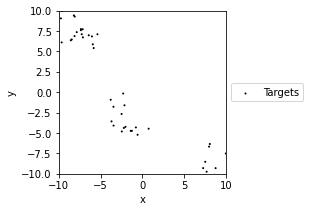

In [ ]:
plot_boundary = (10, 10)
num_experiment = 0
ax = None
ax = plot_targets2d(
    env,
    boundary=plot_boundary,
    color="black",
    alpha=1,
    label="Targets",
    ax=ax,
)

### Create the agents [3 pt]
In the code cell below, create a random search, chemotaxis, and infotaxis agent like we did in Lab 7.

In [ ]:
# Random search agent
diff = DiffusionGrid(min_length=min_length, scale=1)
diff.seed(seed_value)

drift_rate = 1
threshold = 3

# Chemotaxis agent
chemo = AccumulatorGradientGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=drift_rate, 
    threshold=threshold,
    accumulate_sigma=1
)
chemo.seed(seed_value)


# Infotaxis agent
info = AccumulatorInfoGrid(
    min_length=min_length, 
    max_steps=max_steps, 
    drift_rate=drift_rate, 
    threshold=threshold,
    accumulate_sigma=1
)

### Run the experiments [5 pt]
In the code cell below, run 50 experiments of 400 steps each for each of the agents. Note - you may have set the number of experiments and steps earlier during your environment setup code.

In [ ]:
# Experiments
rand_exp = experiment(
    f"rand",
    diff,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
chemo_exp = experiment(
    f"chemo",
    chemo,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)
info_exp = experiment(
    f"info",
    info,
    env,
    num_steps=num_steps,
    num_experiments=num_experiments,
    dump=False,
    split_state=True,
    seed=seed_value
)

rand:   0%|          | 0/50 [00:00<?, ?it/s]

chemo:   0%|          | 0/50 [00:00<?, ?it/s]

info:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualize proportion of time spent on patches [4 pt]
In the code cell below:
- Plot bar plots with error bars for the proportion of time spent on patches for each agent.
- Plot a histogram for the proportion of time spent on patches for each agent.

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

on_off_patch_time:   0%|          | 0/50 [00:00<?, ?it/s]

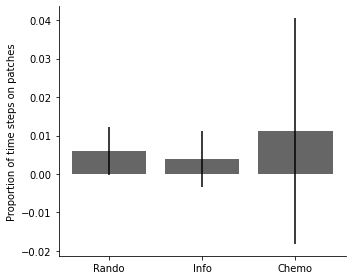

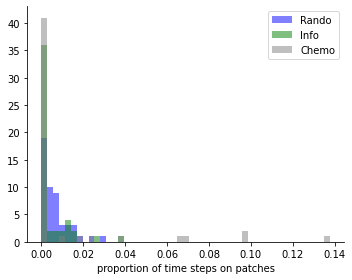

In [ ]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["blue", "green", "grey"]

# Score by on_patch_time #eff
scores = []
for name, res, color in zip(names, results, colors):
    #scores.append(num_death(res))
    on_patch_steps, off_patch_steps = on_off_patch_time(res, num_experiments, patch_locs, radius)
    scores.append(np.divide(on_patch_steps,(np.array(on_patch_steps) + off_patch_steps)))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Proportion of time steps on patches")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("proportion of time steps on patches")
    plt.tight_layout()
    sns.despine()

### Visualize total reward [4 pt]
In the code cell below:
- Plot bar plots with error bars for the total reward for each agent.
- Plot a histogram of total reward for each agent.

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

total_reward:   0%|          | 0/50 [00:00<?, ?it/s]

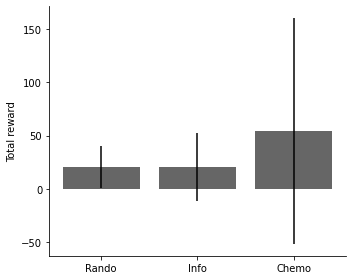

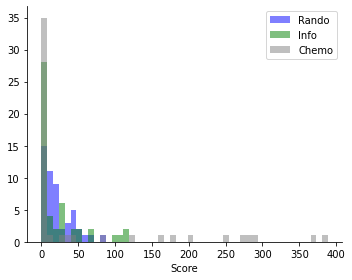

In [ ]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(5, 4))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Total reward")
plt.tight_layout()
sns.despine()

# Dists
fig = plt.figure(figsize=(5, 4))
for (name, s, c) in zip(names, scores, colors):
    plt.hist(s, label=name, color=c, alpha=0.5, bins=np.linspace(0, np.max(scores), 50))
    plt.legend()
    plt.xlabel("Score")
    plt.tight_layout()
    sns.despine()

### Visualize agent deaths [4 pt]
In the code cell below, plot a bar plot of the number of deaths for each agent type.

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

num_death:   0%|          | 0/50 [00:00<?, ?it/s]

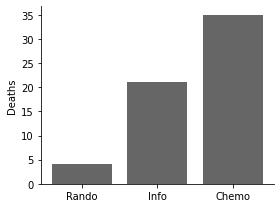

In [ ]:
# Results
results = [rand_exp, info_exp, chemo_exp]
names = ["Rando", "Info", "Chemo"]
colors = ["blue", "green", "grey"]

# Score by eff
scores = []
for name, res, color in zip(names, results, colors):
    scores.append(num_death(res))   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(4, 3))
plt.bar(names, m, yerr=sd, color="black", alpha=0.6)
plt.ylabel("Deaths")
plt.tight_layout()
sns.despine()

### Question 1.2 [7 pt]
Describe the performance of each agent type according to each of the metrics (on-patch proportion, total reward, deaths). Why do you think this pattern of performance occured?

In [ ]:
# For on-patch proportion, the random search agent had the highest proportion, followed by the chemotaxis agent, followed by the infotaxis agent.
# For total reward, the same pattern was seen, but the random agent had a much greater total reward than the other two agents. And for deaths, the
# pattern is the opposite in that the random agent had the least number of deaths, the infotaxis agent had the most, and the chemotaxis agent was
# close to the infotaxis agent in number of deaths.

# This pattern of performance probably occurred because the randomly generated environment was disadvantageous for the chemotaxis and infotaxis
# agents. Given that the two patches were very far apart with a lot of space in between for agents to travel, it could have been difficult for the
# infotaxis agent to get enough "hits" to effectively forage. Similarly, perhaps the scent grid was not helpful for the chemotaxis agent, but it
# was able to start getting rewards once it located a patch.

### Question 1.3.1 [8 pt]
Re-run your simulations above, but change the seed value for the random number generator. Do this four different times, once each with the following values: 2257, 3257, 4257, 5257. 

What do you see in each performance metric of the agents with each new seed value (which specifies different unique environments)?

In [ ]:
# Write your answers here, as Python comments.

# --For seed 2257:--
# The chemotaxic agent outperformed the other agents, and it also spent the most time on a given patch. The random search agent performed the worst
# and spent the least amount of time on a given patch. The number of deaths was very few as only one chemotaxic agent died, and there were no deaths
# among the other two agents.

# --For seed 3257:--
# Again, the chemotaxic agent had a higher average total reward and a higher average on-patch proportion, followed by the infotaxic agent, and lastly
# the random search agent. While the chemotaxic agent didn't score as high as it did in seed 2257, there were no deaths in this environment.

# --For seed 4257:--
# As with the other two seeds, the chemotaxic agent performed the best, with the other two agents following similar trends as before. The infotaxic
# and random search agents scored slightly higher in their total reward when compared to previous environments. Regarding deaths, there were
# approximately 10 or 11 deaths among the chemotaxic agents, and even fewer deaths among the infotaxic agents (3) and random search agents (0).

# --For seed 5257:--
# The chemotaxic agent spent the most time on-patch, followed by the random search agent, followed by the infotaxic agent. Regarding total reward,
# the chemotaxic agent got the highest, and the other two agents scored similarly. There were a lot more deaths in this particular seed, with the
# chemotaxic agent dying the most, followed by the infotaxic agent, followed by the random search agent.

### Question 1.3.2 [8 pt]
What does this (your results recorded in Question 1.3.1) tell you about the the difference between the Info and Chemo agents in particular in environments of this type.

In [ ]:
# These results demonstrate that chemotaxic agents tend to perform best in environments where resources are organized in clumps or patches, and
# information that leads to aforementioned resources are readily available. However, when these scents are not as present, infotaxic agents perform
# better because their behavior is driven by estimating whether a there will be resources ahead.

---
## Section 2 - Reinforcement learning [43 pt]

In the last part of lab 9, you investigated the performance of different reinforcement learnign agents in a changing bandit task, where an arm that used to give the most reward suddenly dropped in reward probability.

In this section of the homework, you will build and test reinforcement learning agents in a different changing bandit task - one where an arm that gave zero reward for most of the experiment changes to being rewarding at a very high probability near the end of each experiment.

Import necessary modules

In [ ]:
import shutil
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import explorationlib

from explorationlib.local_gym import BanditUniform4
from explorationlib.local_gym import BanditChange4
from explorationlib.agent import BanditActorCritic
from explorationlib.agent import Critic
from explorationlib.agent import CriticUCB
from explorationlib.agent import CriticNovelty
from explorationlib.agent import EpsilonActor
from explorationlib.agent import RandomActor
from explorationlib.agent import SequentialActor
from explorationlib.agent import SoftmaxActor
from explorationlib.agent import BoundedRandomActor
from explorationlib.agent import BoundedSequentialActor
from explorationlib.agent import DeterministicActor

from explorationlib.run import experiment
from explorationlib.score import total_reward
from explorationlib.score import action_entropy
from explorationlib.util import select_exp
from explorationlib.util import load
from explorationlib.util import save

from explorationlib.plot import plot_bandit
from explorationlib.plot import plot_bandit_actions
from explorationlib.plot import plot_bandit_critic
from explorationlib.plot import plot_bandit_hist

Set up for pretty plots

In [ ]:
# Pretty plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
%config IPCompleter.greedy=True
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["font.size"] = "16"

# Dev
%load_ext autoreload
%autoreload 2

Plotting the structure of the new bandit task before and after the change

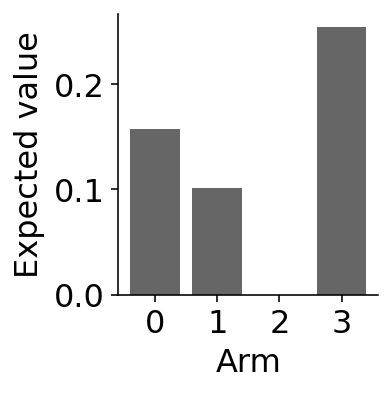

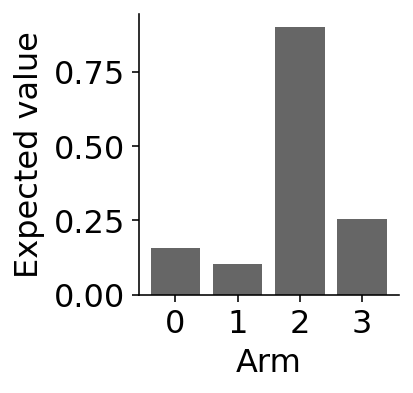

In [ ]:
# Shared env params
seed = 5030

# plot env before
env1 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.0)
env1.seed(seed)
plot_bandit(env1, alpha=0.6)

# plot env after
env2 = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.9)
env2.seed(seed)
plot_bandit(env2, alpha=0.6)

### Create this new changing bandit environment [6 pt]
To make the environment described above, set up a BanditChange4 environment with the following parameters:
- Have the number of trials before the change be 150.
- Have minimum and maximim probability of reward set to 0.1 and 0.3, respectively.
- Have the probability of reward for the "best" arm actually set to 0.0.
- Have the probability of reward for that arm after the change set to 0.9.
- Set the environment's seed to 5030.

[5030]

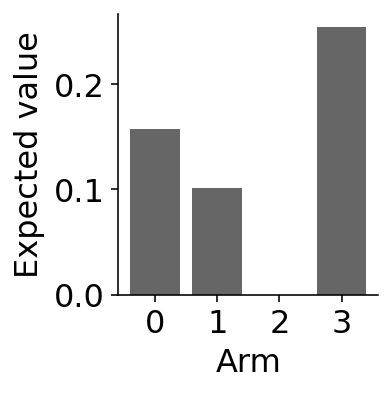

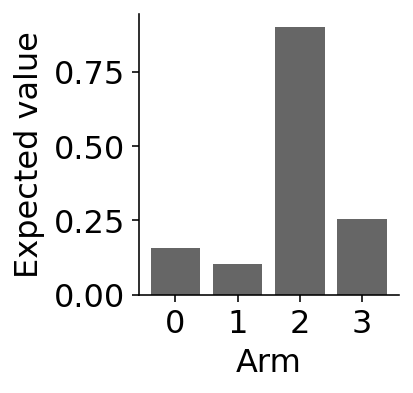

In [ ]:
# Shared env params
num_experiments = 150
seed = 5030

# plot env before
envA = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.0)
envA.seed(seed)
plot_bandit(envA, alpha=0.6)

# plot env after
envB = BanditUniform4(p_min=0.1, p_max=0.3, p_best=0.9)
envB.seed(seed)
plot_bandit(envB, alpha=0.6)

# Create changing bandit environment
env = BanditChange4(num_change=50, p_min=0.1, p_max=0.3, p_best=0.6, p_change=0.1)
env.seed(seed)

### Question 2.1 [7 pt]
When testing later on, we will have each experiment last for 175 steps. What makes this a tricky problem? What would an agent have to do to succeed in this task?

In [ ]:
# Write your answer here, as a Python comment. Explain yourself.

### Creating the reinforcement learning agents [4 pt]

In the code cell below, fill in the code for creating each agent. Use the settings from the lab (repeated here for ease):
- Random agent: no settings needed
- Epsilon-greedy agent: use epsilon value of 0.1
- Upper confidence bound agent: use bonus weight of 0.5
- Softmax actor critic: use beta value of 7

In [ ]:
ran = BanditActorCritic(
    # Fill in random agent code here
    RandomActor(num_actions=env.num_arms),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

epy = BanditActorCritic(
    EpsilonActor(num_actions=env.num_arms, epsilon=0.1),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

ucb = BanditActorCritic(
    DeterministicActor(num_actions=env.num_arms),
    CriticUCB(num_inputs=env.num_arms, default_value=0.0, bonus_weight=0.5)
)

sft = BanditActorCritic(
    SoftmaxActor(num_actions=env.num_arms, beta=7),
    Critic(num_inputs=env.num_arms, default_value=0.0)
)

agents = [ran, epy, ucb, sft]
names = ["random", "ep-greedy", "upper conf. bound", "softmax"]
colors = ["blue", "purple", "orange", "red"]

### Run the experiments [6 pt]

Fill in the code cell below to run 500 experiments for each agent, each with 175 steps. Set the seed to 5030 (have a code line for `seed=5030,` after the code line that sets the number of experiments).

In [ ]:
num_steps = 175
seed = 7030

results = []
for name, agent in zip(names, agents):
    log = experiment(
        f"{name}",
        agent,
        env,
        num_steps=num_steps,
        num_experiments=500,
        dump=False,
        split_state=False,
    )
    results.append(log)

random:   0%|          | 0/500 [00:00<?, ?it/s]

ep-greedy:   0%|          | 0/500 [00:00<?, ?it/s]

upper conf:   0%|          | 0/500 [00:00<?, ?it/s]

softmax:   0%|          | 0/500 [00:00<?, ?it/s]

### Visualize total rewards [4 pt]

In the code cell below, add code to plot the total reward for each agent type in the experiements.

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

total_reward:   0%|          | 0/500 [00:00<?, ?it/s]

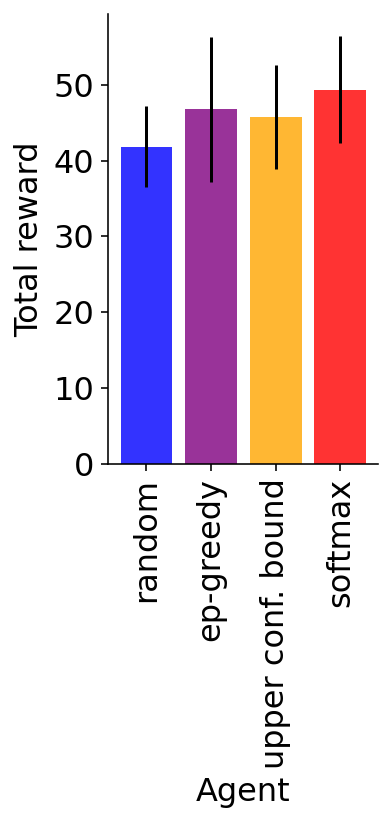

In [ ]:
# Score
scores = []
for name, res, color in zip(names, results, colors):
    r = total_reward(res)
    scores.append(r)   

# Tabulate
m, sd = [], []
for (name, s, c) in zip(names, scores, colors):
    m.append(np.mean(s))
    sd.append(np.std(s))

# Plot means
fig = plt.figure(figsize=(3, 6))
plt.bar(names, m, yerr=sd, color=colors, alpha=0.8)
plt.ylabel("Total reward")
plt.xlabel("Agent")
plt.xticks(rotation=90)
plt.tight_layout()
sns.despine()

### Question 2.2 [8 pt]
How did each of the agents do, compared to one another? Why do you think this is the case?

In [ ]:
# The epsilon greedy agent scored the highest, followed by the random and softmax agentes which scored similarly, followed by the upper confidence
# bound agent which performed the worst. It could be because the epsilon greedy agent, which is greedy for the best option, was able to readjust
# when the "best" arm changed. The upper confidence bound agent probably performed the worst (though still relatively good) because while it was
# boosting less chosen options, it had previously decided that the "best" arm was a suboptimal one before the change and thus did not explore the
# other options as much. The softmax and random agents both probably performed between the other two agents because of the manners in which they go about
# assessing other options (sotfmax samples other options based on temperature parameter before making a decision).

### Question 2.3 [8 pt]

Re-run just the experiments and reward plotting with the following random seeds: 6030, 7030, 8030, and 9030. Make sure you are just changing the seed for the experiments, not for the bandit task itself.

How consistent are the results you see? What does this tell you about the stability of the patterns you described in Question 2.2? Why do you think this is the case?

In [ ]:
# There appeared to be some variability in agents' performance, specifically with the epsilon greedy and softmax agents. The upper confidence bound
# agent consistently scored the worst (not taking into account the random agent). The inconscistency with the other two agents could perhaps be due
# to how the greed variable works in the context of this experiment and how the agents explore other options. Perhaps they settled on relatively good
# options before the "best" option showed up, so the difference in performance wasn't enough for them to switch over for the remainder of the task.

**IMPORTANT** Did you collaborate with anyone on this assignment? If so, list their names here. 
> *Write Name(s) here*

**DUE:** 5pm ET, Dec. 9, 2022. Email the link to the completed notebook on your Github repository to the TA and me via Canvas.